# Exploring the disproportionality of Canadian parties

In [1]:
%matplotlib inline
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from IPython.display import display
from elections import models
from collections import OrderedDict
from django.db.models.base import ModelBase
from IPython.display import HTML
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import os

def columns_reorder_left(dataframe, columns):
    unmentioned = [column for column in dataframe.columns if column not in columns]
    dataframe = dataframe[columns + unmentioned]
    return dataframe

def columns_reorder_after(dataframe, pairs):
    columns = list(dataframe.columns)
    for left, right in pairs.items():
        columns.remove(right)
        columns.insert(columns.index(left) + 1, right)
    return dataframe[columns]

def get_dataframe(qs, mapping, index=None):
    mapping = OrderedDict(mapping)
    qs = qs.objects.all() if isinstance(qs, ModelBase) else qs
    dataframe = pd.DataFrame(list(qs.values(*mapping.keys())))
    dataframe = columns_reorder_left(dataframe, list(mapping.keys()))
    dataframe.rename(columns=mapping, inplace=True)
    if index:
        dataframe = dataframe.set_index(index)
    dataframe = dataframe.sort_index()
    return dataframe

def select_by_index(dataframe, indexes):
    indexer = [slice(None)] * len(dataframe.index.names)
    for key, value in indexes.items():
        indexer[dataframe.index.names.index(key)] = value
    if len(indexer) > 1:
        return dataframe.loc[tuple(indexer), :]
    else:
        return dataframe.loc[tuple(indexer)]

def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes."""
    # calculate evenly-spaced axis angles
    theta = 2 * np.pi * np.linspace(0, 1 - 1. / num_vars, num_vars)
    # rotate theta such that the first axis is at the top
    theta += np.pi / 2

    def draw_poly_frame(self, x0, y0, r):
        # TODO: use transforms to convert (x, y) to (r, theta)
        verts = [(r * np.cos(t) + x0, r * np.sin(t) + y0) for t in theta]
        return plt.Polygon(verts, closed=True, edgecolor='k')

    def draw_circle_frame(self, x0, y0, r):
        return plt.Circle((x0, y0), r)

    frame_dict = {'polygon': draw_poly_frame, 'circle': draw_circle_frame}
    if frame not in frame_dict:
        raise ValueError('unknown value for `frame`: %s' % frame)

    class RadarAxes(PolarAxes):
        """Class for creating a radar chart (a.k.a. a spider or star chart)
        http://en.wikipedia.org/wiki/Radar_chart
        """
        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1
        # define draw_frame method
        draw_frame = frame_dict[frame]

        def fill(self, *args, **kwargs):
            """Override fill so that line is closed by default"""
            closed = kwargs.pop('closed', True)
            return super(RadarAxes, self).fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super(RadarAxes, self).plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(theta * 180 / np.pi, labels)

        def _gen_axes_patch(self):
            x0, y0 = (0.5, 0.5)
            r = 0.5
            return self.draw_frame(x0, y0, r)

    register_projection(RadarAxes)
    return theta

def display_toggler(button="Click to toggle"):
    return HTML("""
        <script>
            function toggle_cell(event) {{
                $(event ? event.target : ".toggler")
                    .parents(".output_wrapper")
                    .prev()
                    .toggle(event ? undefined : false)
            }}
            $(document).ready(setTimeout(toggle_cell, 0))
        </script>
        <p><button class="toggler" onClick="javascript:toggle_cell(event)">{}</button></p>
    """.format(button))

display_toggler("Click to toggle the display the initializing scripts")

In [2]:
elections = get_dataframe(models.GeneralElection, {
    "number": "Election",
    "date_end": "Date",
    "population": "Population",
    "registered": "Registered",
    "ballots_total": "Ballots (Total)",
    "parliament__seats": "Seats",
    "parliament__government_party__name": "Party",
}, ["Election"])
elections['Date'] = pd.to_datetime(elections['Date'])  # TODO: Why isn't this happening automatically?
ridings = get_dataframe(models.ElectionRiding.objects.filter(general_election__isnull=False), {
    "general_election__number": "Election",
    "general_election__date_end": "Election: Date",
    "riding__province__name": "Province",
    "riding__name": "Riding",
    "population": "Population",
    "registered": "Registered",
    "ballots_rejected": "Ballots (Rejected)"
}, ["Election", "Province", "Riding"])
ridings['Election: Date'] = pd.to_datetime(ridings['Election: Date'])
candidates = get_dataframe(models.ElectionCandidate.objects.filter(election_riding__general_election__isnull=False), {
    "election_riding__general_election__number": "Election",
    "election_riding__general_election__date_end": "Election: Date",
    "election_riding__riding__province__name": "Province",
    "election_riding__riding__name": "Riding",
    "name": "Candidate",
    "party__name": "Party",
    "party__color": "Party: Color",
    "election_riding__population": "Riding: Population",
    "election_riding__registered": "Riding: Registered",
    "ballots": "Ballots",
    "elected": "Elected",
    "acclaimed": "Acclaimed",
}, ["Election", "Province", "Riding", "Candidate"])
candidates['Election: Date'] = pd.to_datetime(candidates['Election: Date'])
sitting_vote_participants = get_dataframe(models.SittingVoteParticipant.objects.all(), {
    "sitting_vote__sitting__session__parliament__number": "Parliament",
    "sitting_vote__sitting__session__number": "Session",
    "sitting_vote__sitting__number": "Sitting",
    "sitting_vote__number": "Vote",
    "party__name": "Party",
    "parliamentarian__name": "Parliamentarian",
    "recorded_vote": "Parliamentarian: Vote",
}, ["Parliament", "Session", "Sitting", "Vote", "Party", "Parliamentarian"])
sitting_vote_participants = sitting_vote_participants.reset_index().fillna("Independent").set_index(sitting_vote_participants.index.names)

# Some ridings historically had two seats (Halifax, Victoria, etc). For the purposes of
# calculating voter turnout, we need to define a fractional ballot where a voter's single
# ballot is split in half between two candidates.
ridings = ridings.join(candidates[candidates["Elected"] | candidates["Acclaimed"]].reset_index().groupby(ridings.index.names)["Candidate"].count().to_frame())
ridings = ridings.rename(columns={"Candidate": "Seats"})
candidates = candidates.reset_index().set_index(ridings.index.names).join(ridings["Seats"]).reset_index().set_index(candidates.index.names)
candidates["Ballots (Fractional)"] = candidates["Ballots"] / candidates["Seats"]
del candidates["Seats"]

parties = candidates.reset_index().groupby(["Election", "Party"]).agg({
    "Election: Date": "first",
    'Candidate': 'count',
    'Ballots (Fractional)': 'sum',
    'Elected': 'sum',
    'Acclaimed': 'sum',
    'Party: Color': 'first',
}).rename(columns={
    'Candidate': 'Candidates',
    'Ballots (Fractional)': 'Ballots',
    "Party: Color": "Color",
})
parties["Seats"] = parties["Elected"] + parties["Acclaimed"]
del parties["Elected"]
del parties["Acclaimed"]

# Augment elections with winning party data
elections = elections.reset_index().set_index(parties.index.names).join(parties, rsuffix=" (Party)").reset_index().set_index(elections.index.names).rename(columns={
    'Candidates': 'Party: Candidates',
    'Ballots': 'Party: Ballots',
    'Color': 'Party: Color',
    'Seats (Party)': "Party: Seats",
})
del elections["Election: Date"]
elections = columns_reorder_after(elections, {
    "Seats": "Party",
})

# Copy valid ballots per candidate up to the ridings level
ridings = ridings.join(candidates.reset_index().groupby(ridings.index.names)["Ballots (Fractional)"].sum().to_frame())
ridings = ridings.rename(columns={"Ballots (Fractional)": "Ballots (Valid)"})
ridings = columns_reorder_after(ridings, {"Ballots (Valid)": "Ballots (Rejected)"})

# Copy winning candidate up to the ridings level
ridings_winning_parties = candidates[candidates["Elected"] == True].reset_index().set_index(ridings.index.names)
ridings = ridings.join(ridings_winning_parties[["Candidate", "Party", "Party: Color", "Ballots"]])
ridings = ridings.rename(columns={
    "Candidate": "Elected: Name",
    "Ballots": "Elected: Ballots",
    "Party": "Elected: Party",
    "Color": "Elected: Color",
})

# Copy valid ballots per riding back down to the ridings level
candidates = candidates.reset_index().set_index(ridings.index.names).join(
    ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"})
).reset_index().set_index(candidates.index.names)
candidates = columns_reorder_after(candidates, {"Riding: Registered": "Ballots (Valid)"})
candidates = candidates.rename(columns={
    "Ballots (Valid)": "Riding: Ballots (Valid)",
})

# Copy valid ballots per riding up to the elections level
elections_ballot_sums = ridings.reset_index().groupby(ridings.index.names).agg({"Ballots (Valid)": "first"}).reset_index().groupby(["Election"])["Ballots (Valid)"].sum().to_frame()
elections = elections.join(elections_ballot_sums)
elections = columns_reorder_after(elections, {"Ballots (Total)": "Ballots (Valid)"})

# Augment parties with election level data
elections["Party: Ballot %"] = elections["Party: Ballots"] / elections["Ballots (Valid)"]
elections["Party: Seat %"] = elections["Party: Seats"] / elections["Seats"]
parties["Seat %"] = parties["Seats"] / elections["Seats"]
parties["Vote %"] = parties["Ballots"] / elections["Ballots (Valid)"]
parties["Seat % - Vote %"] = parties["Seat %"] - parties["Vote %"]
parties["Seat % / Vote %"] = parties["Seat %"] / parties["Vote %"]
candidates["Ballot %"] = candidates["Ballots"] / candidates["Riding: Ballots (Valid)"]

display_toggler("Click to toggle the display the data initialization")

## Raw data

Note that there are some hiccups in the raw data one might not expect.

* Until the 28th general election of 1968, ridings were sometimes represented by two MPs (e.g. Halifax). These were later split into multiple ridings.
* Until the 24th general election of 1958, some candidates won by acclaimation, not by election (e.g. Lionel Bertrand). That is to say, they ran unopposed and therefore had no ballots cast in their favour.

These peculiarities should be kept in mind when generating aggregate statistics. For simplicity, let's define "_28plus" suffixed dataframes.

In [3]:
elections["Registered / Population"] = elections["Registered"] / elections["Population"]
elections["Ballots / Population"] = elections["Ballots (Valid)"] / elections["Population"]
elections["Ballots / Registered"] = elections["Ballots (Valid)"] / elections["Registered"]

elections_28plus = select_by_index(elections, {"Election": slice(28, None)})
candidates_28plus = select_by_index(candidates, {"Election": slice(28, None)})
parties_28plus = select_by_index(parties, {"Election": slice(28, None)})
ridings_28plus = select_by_index(ridings, {"Election": slice(28, None)})
del candidates_28plus["Acclaimed"]
del candidates_28plus["Ballots (Fractional)"]
del ridings_28plus["Seats"]

### Elections

In [4]:
display(elections.tail(5))

,Date,Population,Registered,Ballots (Total),Ballots (Valid),Seats,Party,Party: Candidates,Party: Ballots,Party: Color,Party: Seats,Party: Ballot %,Party: Seat %,Registered / Population,Ballots / Population,Ballots / Registered
Election,,,,,,,,,,,,,,,,
38,2004-06-28,30007094,22466621,13683570,13564702.0,308,Lib,308,4982220.0,#EA6D6A,135.0,0.367293,0.438312,0.748710,0.452050,0.603771
39,2006-01-23,30007094,23054615,14908703,14817159.0,308,C,308,5374071.0,#6495ED,124.0,0.362692,0.402597,0.768305,0.493789,0.642698
40,2008-10-14,31612897,23677639,13929093,13834294.0,308,C,307,5209069.0,#6495ED,143.0,0.376533,0.464286,0.748987,0.437616,0.584277
41,2011-05-02,33476688,24257592,14823408,14723980.0,308,C,307,5835270.0,#6495ED,166.0,0.396311,0.538961,0.724611,0.439828,0.606984
42,2015-10-19,33476688,25939742,17711983,17591468.0,338,Lib,338,6942937.0,#EA6D6A,184.0,0.394676,0.544379,0.774860,0.525484,0.678167


### Ridings

In [5]:
display(select_by_index(ridings, {"Riding": ["HALIFAX"], "Election": [*range(40, 42 + 1)]}))

,,,Election: Date,Population,Registered,Seats,Ballots (Valid),Ballots (Rejected),Elected: Name,Elected: Party,Party: Color,Elected: Ballots
Election,Province,Riding,,,,,,,,,,
40,Nova Scotia,HALIFAX,2008-10-14,89448.0,74717.0,1,45098.0,230.0,"LESLIE, Megan",N.D.P.,#F4A460,19252.0
41,Nova Scotia,HALIFAX,2011-05-02,89448.0,73357.0,1,45987.0,241.0,"LESLIE, Megan",N.D.P.,#F4A460,23746.0
42,Nova Scotia,HALIFAX,2015-10-19,92643.0,73379.0,1,53032.0,259.0,"FILLMORE, Andy",Lib,#EA6D6A,27431.0


### Candidates

In [6]:
display(select_by_index(candidates[candidates["Ballot %"] > .01], {
    "Election": [42],
    "Riding": ["VANCOUVER QUADRA"],
}))

Election: Date  \
Election Province         Riding           Candidate                        
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott      2015-10-19   
                                           CONSTABLE, Kris     2015-10-19   
                                           LOCKHART, Blair     2015-10-19   
                                           MURRAY, Joyce       2015-10-19   

                                                             Party  \
Election Province         Riding           Candidate                 
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott   N.D.P.   
                                           CONSTABLE, Kris    G.P.   
                                           LOCKHART, Blair       C   
                                           MURRAY, Joyce       Lib   

                                                           Party: Color  \
Election Province         Riding           Candidate                      
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott       #F4A460   
                                           CONSTABLE, Kris      #99C955   
                                           LOCKHART, Blair      #6495ED   
                                           MURRAY, Joyce        #EA6D6A   

                                                            Riding: Population  \
Election Province         Riding           Candidate                             
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott             102416.0   
                                           CONSTABLE, Kris            102416.0   
                                           LOCKHART, Blair            102416.0   
                                           MURRAY, Joyce              102416.0   

                                                            Riding: Registered  \
Election Province         Riding           Candidate                             
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott              76038.0   
                                           CONSTABLE, Kris             76038.0   
                                           LOCKHART, Blair             76038.0   
                                           MURRAY, Joyce               76038.0   

                                                            Riding: Ballots (Valid)  \
Election Province         Riding           Candidate                                  
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott                   52972.0   
                                           CONSTABLE, Kris                  52972.0   
                                           LOCKHART, Blair                  52972.0   
                                           MURRAY, Joyce                    52972.0   

                                                            Ballots Elected  \
Election Province         Riding           Candidate                          
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott    5748.0   False   
                                           CONSTABLE, Kris   2229.0   False   
                                           LOCKHART, Blair  13683.0   False   
                                           MURRAY, Joyce    31102.0    True   

                                                           Acclaimed  \
Election Province         Riding           Candidate                   
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott      False   
                                           CONSTABLE, Kris     False   
                                           LOCKHART, Blair     False   
                                           MURRAY, Joyce       False   

                                                            Ballots (Fractional)  \
Election Province         Riding           Candidate                               
42       British Columbia VANCOUVER QUADRA ANDREWS, Scott                 5748.0   
                                           CONSTABLE, K

### Parties

In [7]:
display(select_by_index(
    parties[parties["Seats"] > 0],
    {"Election": [42]},
))

Election: Date  Candidates    Ballots    Color  Seats  \
Election Party                                                          
42       B.Q.       2015-10-19          78   821144.0  #87CEFA   10.0   
         C          2015-10-19         338  5613633.0  #6495ED   99.0   
         G.P.       2015-10-19         336   602933.0  #99C955    1.0   
         Lib        2015-10-19         338  6942937.0  #EA6D6A  184.0   
         N.D.P.     2015-10-19         338  3469368.0  #F4A460   44.0   

                   Seat %    Vote %  Seat % - Vote %  Seat % / Vote %  
Election Party                                                         
42       B.Q.    0.029586  0.046679        -0.017093         0.633820  
         C       0.292899  0.319111        -0.026212         0.917860  
         G.P.    0.002959  0.034274        -0.031316         0.086321  
         Lib     0.544379  0.394676         0.149702         1.379304  
         N.D.P.  0.130178  0.197219        -0.067041         0.660066

### Other data types

A fair amount of further data is stored in this dataset. Photos for MPs, links to Wikipedia pages, bill titles, etc. If there's more data you'd like to see, send me an email at bradbeattie@gmail.com.

In [8]:
print(", ".join(sorted(
    str(getattr(models, model_name)._meta.verbose_name_plural.title())
    for model_name in dir(models)
    if isinstance(getattr(models, model_name), ModelBase)
)))

Bills, Committees, Election Candidates, Election Ridings, General Elections, Parliamentarians, Parliaments, Parties, Provinces, Ridings, Sessions, Sitting Vote Participants, Sitting Votes, Sittings


## Is there a clear relation between popular vote and disproportionality?

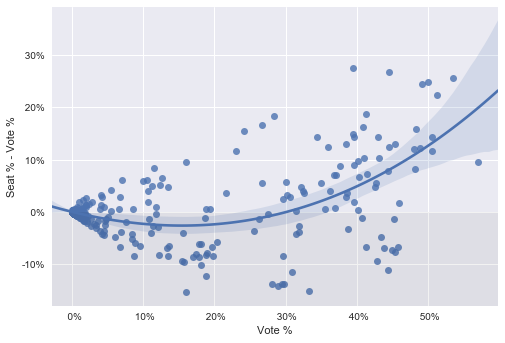

In [9]:
df = parties
df = df.reset_index()
df = df[(df["Party"] != "Independent")]
g = sns.regplot(x="Vote %", y="Seat % - Vote %", data=df, order=3)
g.add_patch(patches.Rectangle((-1, -1), 2, 1, alpha=0.05, facecolor="black"))
g.set_xticklabels(['{:3.0f}%'.format(x * 100) for x in g.get_xticks()])
g.set_yticklabels(['{:3.0f}%'.format(y * 100) for y in g.get_yticks()]);

## How has the registered voting population and voter turnout changed over time?

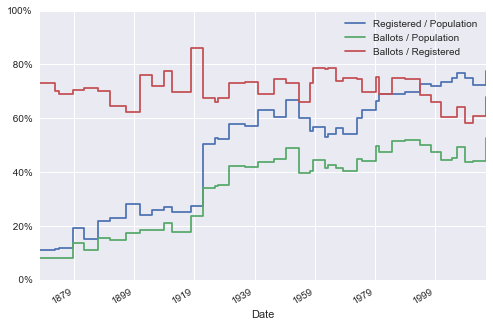

In [10]:
df = elections
plot = df.plot(x="Date", y=[
    "Registered / Population",
    "Ballots / Population",
    "Ballots / Registered",
], drawstyle="steps-post")
plot.set(ylim=(0, 1));
plot.set_yticklabels(['{:3.0f}%'.format(y * 100) for y in plot.get_yticks()]);

## Which parties have held power and which majorities have been false?

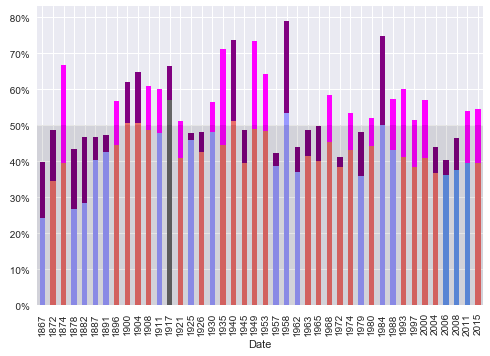

In [11]:
df = elections
df["Kind"] = np.where(df["Party: Seat %"] < 0.5, "minority", np.where(df["Party: Ballot %"] < 0.5, "false majority", "majority"))
kind_colors = { "minority": "purple", "majority": "purple", "false majority": "magenta"}
df["Party: Seat % - Ballot %"] = df["Party: Seat %"] - df["Party: Ballot %"]
plot = df.plot(
    x=df["Date"].dt.year,
    y=['Party: Ballot %', 'Party: Seat % - Ballot %'],
    kind='bar',
    legend=False,
    stacked=True,
    color=[
        list(df["Party: Color"]),
        [kind_colors.get(kind) for kind in df["Kind"]]
    ],
)

plot.set_yticklabels(['{:3.0f}%'.format(y * 100) for y in plot.get_yticks()]);
plot.add_patch(patches.Rectangle((-1, -1), len(df) + 1, 1.5, alpha=0.1, facecolor="black"))

## Do ridings with more registered voters prefer certain parties?

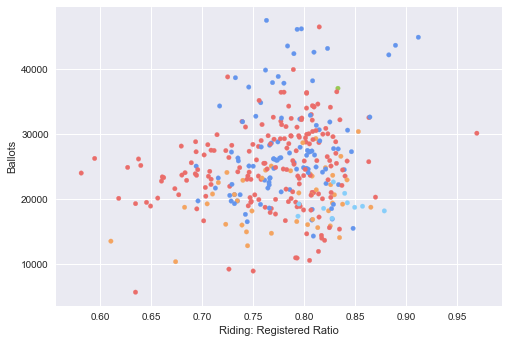

In [12]:
df = select_by_index(candidates, {"Election": 42})
df = df[df["Elected"]]
df["Riding: Registered Ratio"] = df["Riding: Registered"] / df["Riding: Population"]
plot = df.plot(kind="scatter", x="Riding: Registered Ratio", y="Ballots", c=df["Party: Color"]);

## How much overlap is there in winning ballot percentages per party?

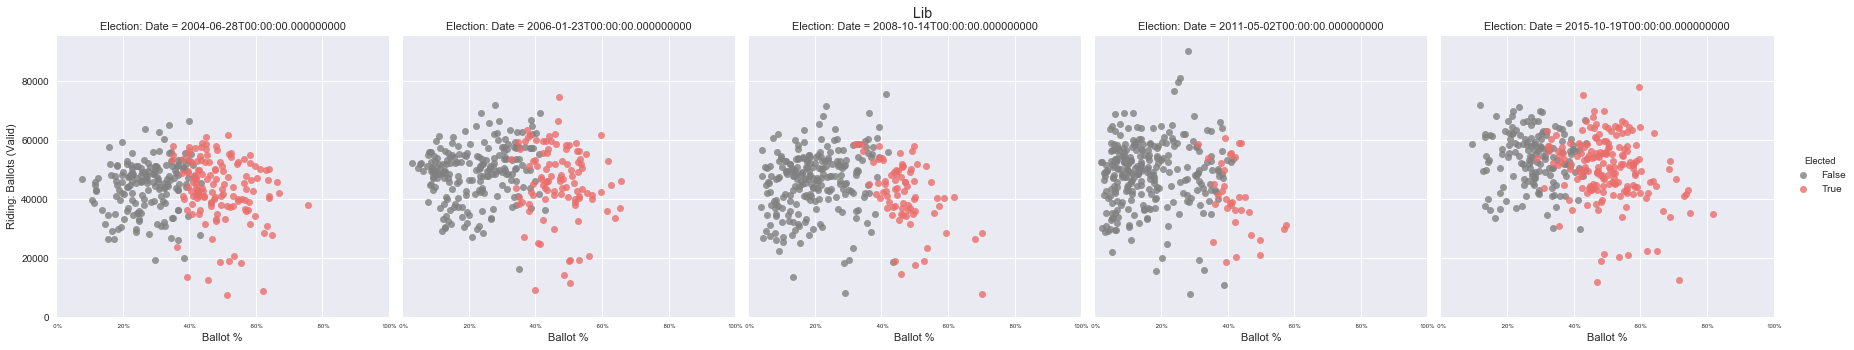

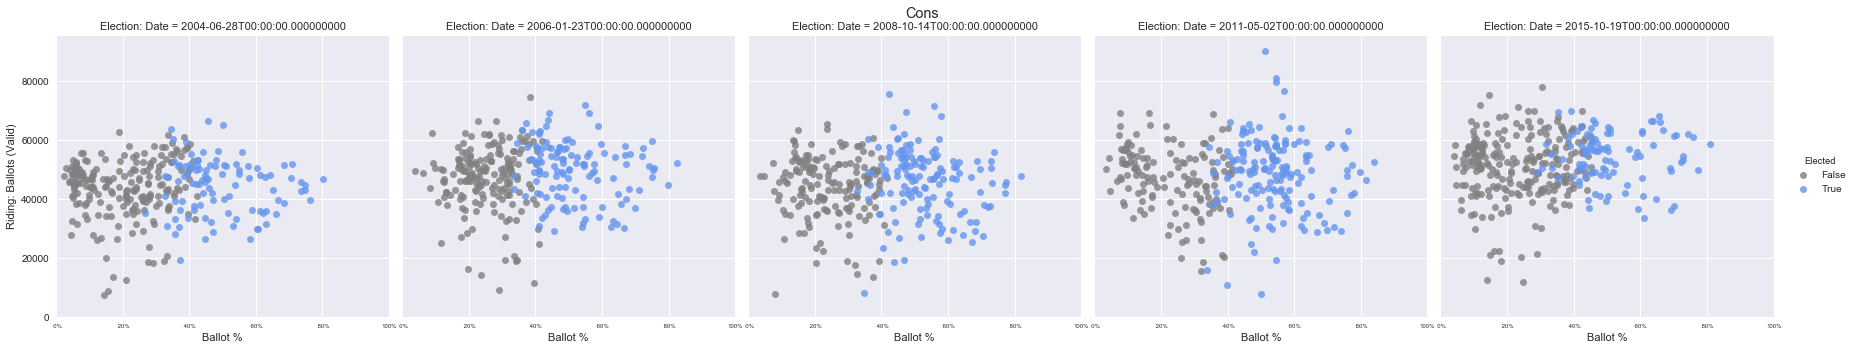

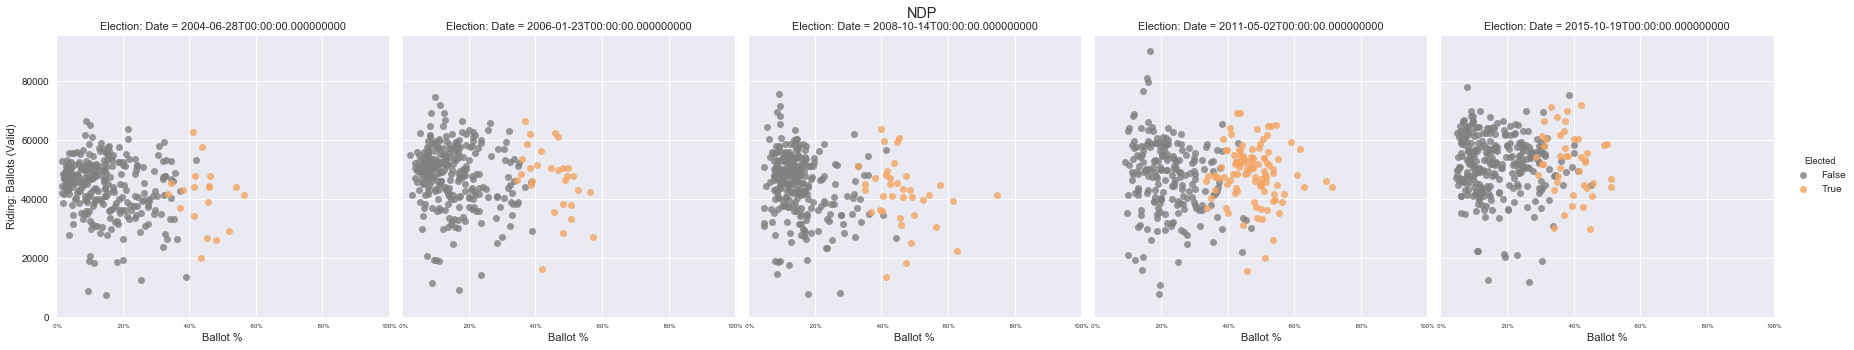

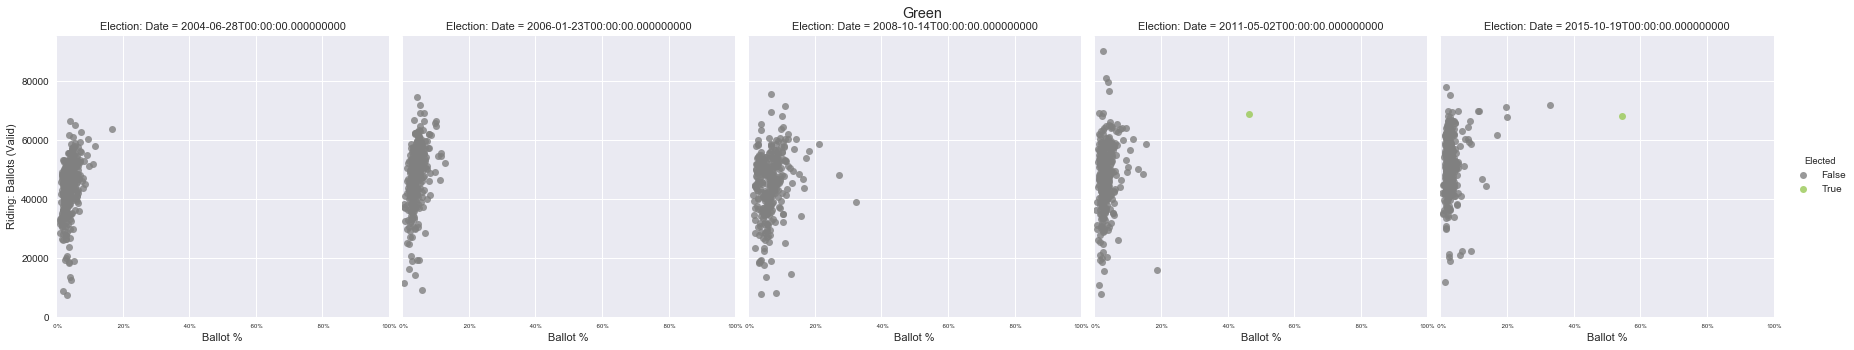

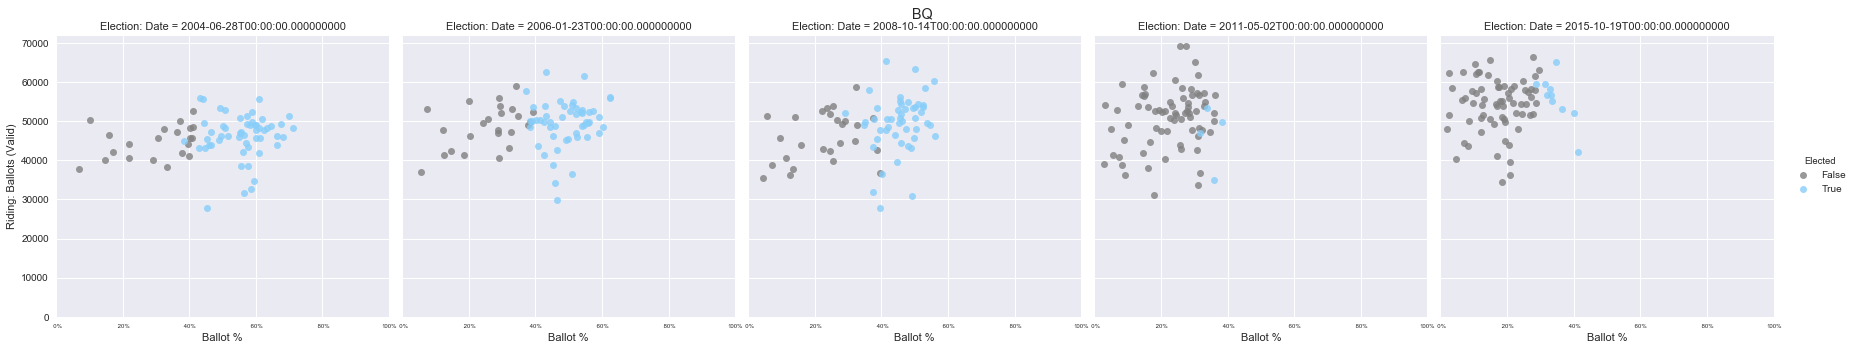

In [13]:
from_year = 2000
df = select_by_index(candidates, {"Election": [*range(38, 42 + 1)]})
dfilters = (
    ("Lib", df["Party"] == "Lib"),
    ("Cons", df["Party"].isin(("P.C.", "CA", "Ref.", "C"))),
    ("NDP", df["Party"] == "N.D.P."),
    ("Green", df["Party"] == "G.P."),
    ("BQ", df["Party"] == "B.Q."),
)
for name, dfilter in dfilters:
    df2 = df[dfilter]
    sns.set_palette(sns.color_palette(["grey", df2[df2["Elected"] == True]["Party: Color"].iloc[-1]]))
    g = sns.lmplot(
        x="Ballot %",
        y="Riding: Ballots (Valid)",
        hue="Elected",
        col="Election: Date",
        data=df2,
        fit_reg=False,
    )
    g.set(ylim=(0, None))
    g.set(xlim=(0.0, 1.0))
    for ax in g.axes.flatten():
        ax.set_xticklabels(ax.get_xticklabels(), fontsize=6)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: '{:3.0f}%'.format(x * 100)))
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle(name)
    plt.show()

## Which parliamentarians stray from or adhere to party lines the most?

In [14]:
# Determine how parties vote as a whole
votes_per_party_per_record = sitting_vote_participants.reset_index().groupby(
    ["Parliament", "Session", "Sitting", "Vote", "Party", "Parliamentarian: Vote"],
)["Parliamentarian: Vote"].count().to_frame().rename(columns={"Parliamentarian: Vote": "Count"})
votes_per_party = votes_per_party_per_record.reset_index().groupby(
    ["Parliament", "Session", "Sitting", "Vote", "Party"],
)["Count"].sum().to_frame()
votes_per_party_per_record = votes_per_party_per_record.reset_index().set_index(
    votes_per_party.index.names
).join(votes_per_party["Count"], rsuffix=" (Total)").reset_index().set_index(
    votes_per_party_per_record.index.names
)
votes_per_party_per_record["Party: Majority Vote"] = round(votes_per_party_per_record["Count"] / votes_per_party_per_record["Count (Total)"])

# Calculate how similar a parliamentarian is to their party
party_adherence = sitting_vote_participants.reset_index().set_index(
    votes_per_party_per_record.index.names,
).join(votes_per_party_per_record["Party: Majority Vote"]).reset_index().set_index(
    sitting_vote_participants.index.names,
).reset_index().groupby([
    "Parliament", "Session", "Party", "Parliamentarian",
]).agg({
    "Party: Majority Vote": "mean",
}).rename(columns={"Party: Majority Vote": "Adherence"})

# Show parliamentarians that vote against their party lines
display(select_by_index(party_adherence[party_adherence["Adherence"] < 0.97], {"Parliament": [42]}))

# Show parliamentarians that 100% adhere to their party lines
display(select_by_index(party_adherence[party_adherence["Adherence"] == 1], {"Parliament": [42]}))

# TODO: Using voting records from previous parliaments,
#       determine how likely a parliamentarian is to be relected
#       based on their adherence to party lines in the preceding parliament

Adherence
Parliament Session Party  Parliamentarian                    
42         1       C      ALBAS, Dan                 0.967078
                          BOUCHER, Sylvie            0.951754
                          CHONG, Mike                0.935644
                          KENT, Peter                0.948819
                          LIEPERT, Ron               0.958159
                          OBHRAI, Deepak             0.928571
                          RAITT, Lisa                0.969697
                          RAYES, Alain               0.965517
                          STANTON, Bruce             0.958333
                          TILSON, David              0.963158
                          WEBBER, Len                0.963563
                   Lib    ALDAG, John                0.969828
                          ANANDASANGAREE, Gary       0.961702
                          ARSENEAULT, René           0.968627
                          CHAN, Arnold               0.951923
                          DAMOFF, Pam                0.959184
                          ERSKINE-SMITH, Nathaniel   0.882927
                          FOOTE, Judy                0.867841
                          FRAGISKATOS, Peter         0.967480
                          FREELAND, Chrystia         0.922581
                          HARDIE, Ken                0.968750
                          HARVEY, TJ                 0.969298
                          HOUSEFATHER, Anthony       0.967611
                          JONES, Yvonne              0.968912
                          OLIPHANT, Rob              0.958848
                          OUELLETTE, Robert-Falcon   0.936975
                   N.D.P. MOORE, Christine           0.751073

Adherence
Parliament Session Party       Parliamentarian                    
42         1       C           BEZAN, James                    1.0
                               CARRIE, Colin                   1.0
                               FAST, Ed                        1.0
                               FINLEY, Diane                   1.0
                               HILLYER, Jim                    1.0
                               HOBACK, Randy                   1.0
                               KENNEY, Jason                   1.0
                               LEITCH, Kellie                  1.0
                               LOBB, Ben                       1.0
                               MOTZ, Glen                      1.0
                               O'TOOLE, Erin                   1.0
                               SAROYA, Bob                     1.0
                               SCHEER, Andrew                  1.0
                               SWEET, David                    1.0
                   G.P.        MAY, Elizabeth                  1.0
                   Independent TOOTOO, Hunter                  1.0
                   Lib         BRETON, Pierre                  1.0
                               BÉLANGER, Mauril                1.0
                               DION, Stéphane                  1.0
                               LAUZON, Stéphane                1.0
                               LEVITT, Michael                 1.0
                               LONG, Wayne                     1.0
                               MCGUINTY, David                 1.0
                               SANGHA, Ramesh                  1.0
                               TOOTOO, Hunter                  1.0
                   N.D.P.      ASHTON, Niki                    1.0
                               BENSON, Sheri                   1.0
                               BOUTIN-SWEET, Marjolaine        1.0
                               CARON, Guy                      1.0
                               CULLEN, Nathan                  1.0
                               DONNELLY, Fin                   1.0
                               DUVALL, Scott                   1.0
                               HARDCASTLE, Cheryl              1.0
                               HUGHES, Carol                   1.0
                               JOLIBOIS, Georgina              1.0
                               LAVERDIÈRE, Hélène              1.0
                               MASSE, Brian                    1.0
                               MATHYSSEN, Irene                1.0
                               RAMSEY, Tracey                  1.0
                               SAGANASH, Romeo                 1.0
                               SANSOUCY, Brigitte              1.0

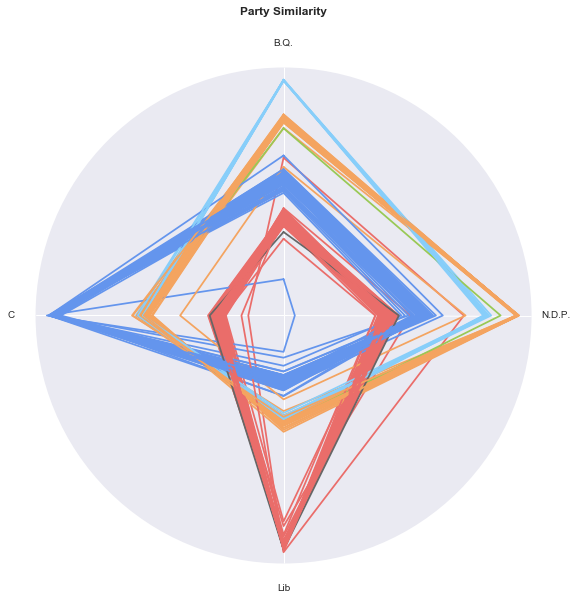

In [15]:
def get_mp_similarity(df, parliament):
    top5 = df.reset_index()
    top5 = top5[top5["Parliament"] == parliament]

    per_party_per_vote = top5[top5["Party"].isin(("Lib", "C", "N.D.P.", "B.Q."))].groupby(
        ["Parliament", "Session", "Sitting", "Vote", "Parliamentarian: Vote", "Party"],
    )["Parliamentarian: Vote"].count().to_frame().rename(columns={"Parliamentarian: Vote": "Count"})
    per_party_per_vote = per_party_per_vote.unstack(fill_value=0)
    
    per_party = top5.reset_index().groupby(
        ["Parliament", "Session", "Sitting", "Vote", "Party"],
    )["Party"].count().to_frame().rename(columns={"Party": "Total"}).unstack().fillna(100000)

    df3 = per_party_per_vote.unstack(fill_value=0).stack().reset_index()
    df1 = per_party.reset_index()
    df2 = df1
    while len(df2) < len(df3):
        df2 = df2.append(df1)
    df2 = df2.sort_values(
        ["Parliament", "Session", "Sitting", "Vote"],
    )
    df2.index = range(len(df2))

    assert len(df3) == len(df2)
    ratio = (df3["Count"] / df2["Total"]).fillna(0)
    ratio.columns = pd.MultiIndex.from_product([['Ratio'], ratio.columns])

    df3[ratio.columns] = ratio
    del df3["Count"]
    vote_ratios = df3

    import warnings
    warnings.simplefilter(action='ignore', category=UserWarning)
    warnings.simplefilter(action='ignore', category=pd.io.pytables.PerformanceWarning)

    df1 = top5.reset_index()
    dfs = []
    for row in list(df1.groupby(["Parliamentarian"]).agg({
        "Parliamentarian": "first",
    }).iterrows()):
        parliamentarian = row[0]
        dfp = df1[df1["Parliamentarian"] == parliamentarian]
        dfp = pd.merge(dfp, vote_ratios, on=["Parliament", "Session", "Sitting", "Vote", "Parliamentarian: Vote"], how='inner')
        del dfp["Parliamentarian: Vote"]
        dfg = dfp.groupby(["Parliament", "Session", "Parliamentarian", "Party"]).agg({
            ("Ratio", "B.Q."): "mean",
            ("Ratio", "C"): "mean",
            #("Ratio", "G.P."): "mean",
            ("Ratio", "Lib"): "mean",
            ("Ratio", "N.D.P."): "mean",
        }).reset_index().set_index(["Parliament", "Session"])
        dfs.append(dfg)

    mp_party_similarity = pd.concat(dfs, ignore_index=True)
    return mp_party_similarity

mp_party_similarity = get_mp_similarity(sitting_vote_participants, 42)
spoke_labels = mp_party_similarity.columns.levels[1].values[0:4]
theta = radar_factory(len(spoke_labels))

fig = plt.figure(figsize=(20,20))
# adjust spacing around the subplots
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
title_list = ['Party Similarity']

rows = []
colors = []
for index, row in mp_party_similarity.iterrows():
    name, party, *values = row
    try:
        color = select_by_index(parties, {"Election": [42], "Party": party})["Color"][0]
    except:
        color = "#666666"
    colors.append(color)
    rows.append(values)

data = {'Party Similarity': rows}
# chemicals range from 0 to 1
radial_grid = [2., 4., 6., 8.]
# If you don't care about the order, you can loop over data_dict.items()
for n, title in enumerate(title_list):
    ax = fig.add_subplot(2, 2, n + 1, projection='radar')
    plt.rgrids(radial_grid)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(data[title], colors):
        ax.plot(theta, d, color=color)
    ax.set_varlabels(spoke_labels)
plt.show()

In [16]:
sitting_vote_participants = get_dataframe(models.SittingVoteParticipant.objects.all(), {
    "sitting_vote__sitting__session__parliament__number": "Parliament",
    "sitting_vote__sitting__session__number": "Session",
    "sitting_vote__sitting__number": "Sitting",
    "sitting_vote__number": "Vote",
    "party__name": "Party",
    "parliamentarian__name": "Parliamentarian",
    "recorded_vote": "Parliamentarian: Vote",
}, ["Parliament", "Session", "Sitting", "Vote", "Party", "Parliamentarian"])
sitting_vote_participants = sitting_vote_participants.reset_index().fillna("Independent").set_index(sitting_vote_participants.index.names)
display(sitting_vote_participants.head(5))

Parliamentarian: Vote
Parliament Session Sitting Vote Party Parliamentarian                          
38         1       10      1    B.Q.  ANDRÉ, Guy                              2
                                      ASSELIN, Gérard                         2
                                      BACHAND, Claude                         2
                                      BELLAVANCE, André                       2
                                      BERGERON, Stéphane                      2

## MPs most like and least like other parties

In [17]:
df = mp_party_similarity.reset_index()
for source in mp_party_similarity.columns.levels[1].values[0:5]:
    if source == "G.P.":
        continue
    for target in mp_party_similarity.columns.levels[1].values[0:5]:
        display(HTML("""<h3>{} MPs</h3>""".format(source)))
        display(HTML("""<h4>Most like {}</h4>""".format(target)))
        display(df[df["Party"] == source].sort_values(("Ratio", target), ascending=False).head(5))
        display(HTML("""<h4>Least like {}</h4>""".format(target)))
        display(df[df["Party"] == source].sort_values(("Ratio", target)).head(5))

index   Parliamentarian Party     Ratio                              
                                       B.Q.         C       Lib    N.D.P.
247   247  PLAMONDON, Louis  B.Q.  0.996366  0.572583  0.397169  0.860253
124   124    GILL, Marilène  B.Q.  0.994732  0.567229  0.421017  0.851207
112   112     FORTIN, Rhéal  B.Q.  0.994020  0.570172  0.395005  0.870941
308   308    THÉRIAULT, Luc  B.Q.  0.993927  0.574325  0.382831  0.848892
41     41  BOUDRIAS, Michel  B.Q.  0.993624  0.582765  0.400138  0.854888

index         Parliamentarian Party     Ratio                      \
                                             B.Q.         C       Lib   
197   197           MARCIL, Simon  B.Q.  0.990821  0.568567  0.408343   
299   299      STE-MARIE, Gabriel  B.Q.  0.991213  0.571905  0.409500   
22     22  BARSALOU-DUVAL, Xavier  B.Q.  0.992769  0.574048  0.415247   
24     24         BEAULIEU, Mario  B.Q.  0.993166  0.604943  0.398458   
241   241          PAUZÉ, Monique  B.Q.  0.993585  0.596530  0.403125   

               
       N.D.P.  
197  0.857329  
299  0.845955  
22   0.835409  
24   0.850932  
241  0.841591

index         Parliamentarian Party     Ratio                      \
                                             B.Q.         C       Lib   
24     24         BEAULIEU, Mario  B.Q.  0.993166  0.604943  0.398458   
241   241          PAUZÉ, Monique  B.Q.  0.993585  0.596530  0.403125   
41     41        BOUDRIAS, Michel  B.Q.  0.993624  0.582765  0.400138   
308   308          THÉRIAULT, Luc  B.Q.  0.993927  0.574325  0.382831   
22     22  BARSALOU-DUVAL, Xavier  B.Q.  0.992769  0.574048  0.415247   

               
       N.D.P.  
24   0.850932  
241  0.841591  
41   0.854888  
308  0.848892  
22   0.835409

index     Parliamentarian Party     Ratio                              
                                         B.Q.         C       Lib    N.D.P.
124   124      GILL, Marilène  B.Q.  0.994732  0.567229  0.421017  0.851207
197   197       MARCIL, Simon  B.Q.  0.990821  0.568567  0.408343  0.857329
112   112       FORTIN, Rhéal  B.Q.  0.994020  0.570172  0.395005  0.870941
299   299  STE-MARIE, Gabriel  B.Q.  0.991213  0.571905  0.409500  0.845955
247   247    PLAMONDON, Louis  B.Q.  0.996366  0.572583  0.397169  0.860253

index         Parliamentarian Party     Ratio                      \
                                             B.Q.         C       Lib   
124   124          GILL, Marilène  B.Q.  0.994732  0.567229  0.421017   
22     22  BARSALOU-DUVAL, Xavier  B.Q.  0.992769  0.574048  0.415247   
299   299      STE-MARIE, Gabriel  B.Q.  0.991213  0.571905  0.409500   
197   197           MARCIL, Simon  B.Q.  0.990821  0.568567  0.408343   
241   241          PAUZÉ, Monique  B.Q.  0.993585  0.596530  0.403125   

               
       N.D.P.  
124  0.851207  
22   0.835409  
299  0.845955  
197  0.857329  
241  0.841591

index   Parliamentarian Party     Ratio                              
                                       B.Q.         C       Lib    N.D.P.
308   308    THÉRIAULT, Luc  B.Q.  0.993927  0.574325  0.382831  0.848892
112   112     FORTIN, Rhéal  B.Q.  0.994020  0.570172  0.395005  0.870941
247   247  PLAMONDON, Louis  B.Q.  0.996366  0.572583  0.397169  0.860253
24     24   BEAULIEU, Mario  B.Q.  0.993166  0.604943  0.398458  0.850932
41     41  BOUDRIAS, Michel  B.Q.  0.993624  0.582765  0.400138  0.854888

index   Parliamentarian Party     Ratio                              
                                       B.Q.         C       Lib    N.D.P.
112   112     FORTIN, Rhéal  B.Q.  0.994020  0.570172  0.395005  0.870941
247   247  PLAMONDON, Louis  B.Q.  0.996366  0.572583  0.397169  0.860253
197   197     MARCIL, Simon  B.Q.  0.990821  0.568567  0.408343  0.857329
41     41  BOUDRIAS, Michel  B.Q.  0.993624  0.582765  0.400138  0.854888
124   124    GILL, Marilène  B.Q.  0.994732  0.567229  0.421017  0.851207

index         Parliamentarian Party     Ratio                      \
                                             B.Q.         C       Lib   
22     22  BARSALOU-DUVAL, Xavier  B.Q.  0.992769  0.574048  0.415247   
241   241          PAUZÉ, Monique  B.Q.  0.993585  0.596530  0.403125   
299   299      STE-MARIE, Gabriel  B.Q.  0.991213  0.571905  0.409500   
308   308          THÉRIAULT, Luc  B.Q.  0.993927  0.574325  0.382831   
24     24         BEAULIEU, Mario  B.Q.  0.993166  0.604943  0.398458   

               
       N.D.P.  
22   0.835409  
241  0.841591  
299  0.845955  
308  0.848892  
24   0.850932

KeyError: ('Ratio', '')